Import needed libraries!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)

from sklearn.metrics import confusion_matrix
import itertools

import keras
import shutil
from keras import regularizers
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras import regularizers
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
from zipfile import ZipFile

Mount Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set the base directory and image directory
base_skin_dir = '/content/drive/MyDrive/Skin Lesions Dataset.zip'
base_skin_metadata = '/content/drive/MyDrive/HAM10000_MetaData.csv'

destination_dir = '/content/Skin Lesions'

# Unzip the file
with ZipFile(base_skin_dir, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

#Copy the metadata CSV to the destination folder
shutil.copy(base_skin_metadata, destination_dir)

# List the extracted files
extracted_files = os.listdir(destination_dir)
print("Extracted files:", extracted_files)

base_skin_dir = os.path.join('./Skin Lesions/Skin Lesions Dataset')

Extracted files: ['HAM10000_MetaData.csv', 'Skin Lesions Dataset']


Image pre-processing

In [ ]:
# Merge images from the folder into a dictionary with image IDs as keys and file paths as values
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Read the skin lesions csv

In [ ]:
# Step 4: Create new columns in the DataFrame (path to image, human-readable name, and categorical code) and review the DataFrame
tile_df = pd.read_csv("./Skin Lesions/HAM10000_MetaData.csv")


Link text images to the images ids from each row and add an extra column.


In [ ]:
# Create some new columns (path to image, human-readable name) and review them

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes

tile_df.tail()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,image,path
5010,1761,HAM_0005274,ISIC_0032766,mel,histo,55.0,male,upper extremity,Melanoma,5,[[[ 0 0 0]\r\n [ 0 0 0]\r\n [ 0 0 0]\r...,./Skin Lesions/Skin Lesions Dataset/ISIC_00327...
5011,2331,HAM_0006617,ISIC_0024669,vasc,histo,25.0,female,abdomen,Vascular lesions,6,[[[161 141 132]\r\n [158 132 109]\r\n [166 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00246...
5012,500,HAM_0001245,ISIC_0031168,bkl,histo,60.0,male,chest,Benign keratosis-like lesions,2,[[[168 130 141]\r\n [168 128 137]\r\n [168 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00311...
5013,300,HAM_0004114,ISIC_0026844,bkl,histo,75.0,male,back,Benign keratosis-like lesions,2,[[[140 125 132]\r\n [141 126 133]\r\n [152 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00268...
5014,2271,HAM_0007530,ISIC_0024410,mel,histo,30.0,male,chest,Melanoma,5,[[[160 138 151]\r\n [170 149 168]\r\n [169 1...,./Skin Lesions/Skin Lesions Dataset/ISIC_00244...


In [ ]:
# Print the total number of rows and columns
print("Total rows and columns before removing 'None' values:", tile_df.shape)

# Remove rows with 'None' in the 'path' column
tile_df = tile_df[tile_df['path'].notna()]

# Print the total number of rows and columns after removing 'None' values
print("Total rows and columns after removing 'None' values:", tile_df.shape)


Total rows and columns before removing 'None' values: (5015, 12)
Total rows and columns after removing 'None' values: (5015, 12)


The distribution of different cell types

<Axes: >

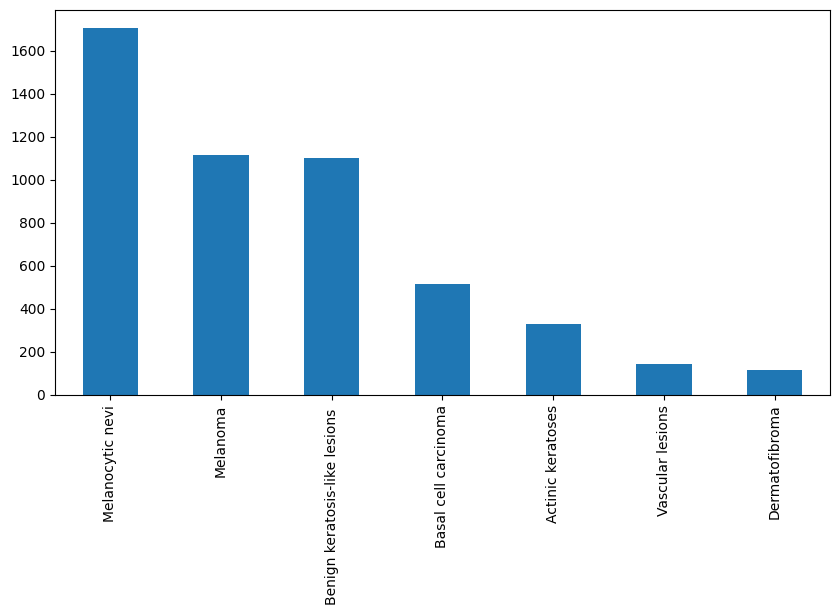

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Too many melanocytic nevi - let's balance it a bit!

<Axes: >

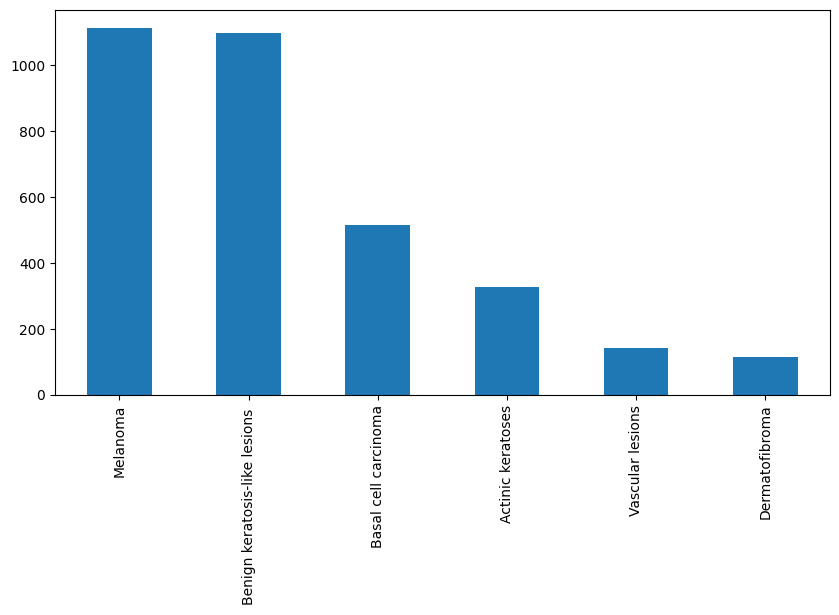

In [ ]:
tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
input_dims = (32, 32)
input_shape = input_dims + (3,)

# Load in all of the images into memory - this will take a while.
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow

tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))

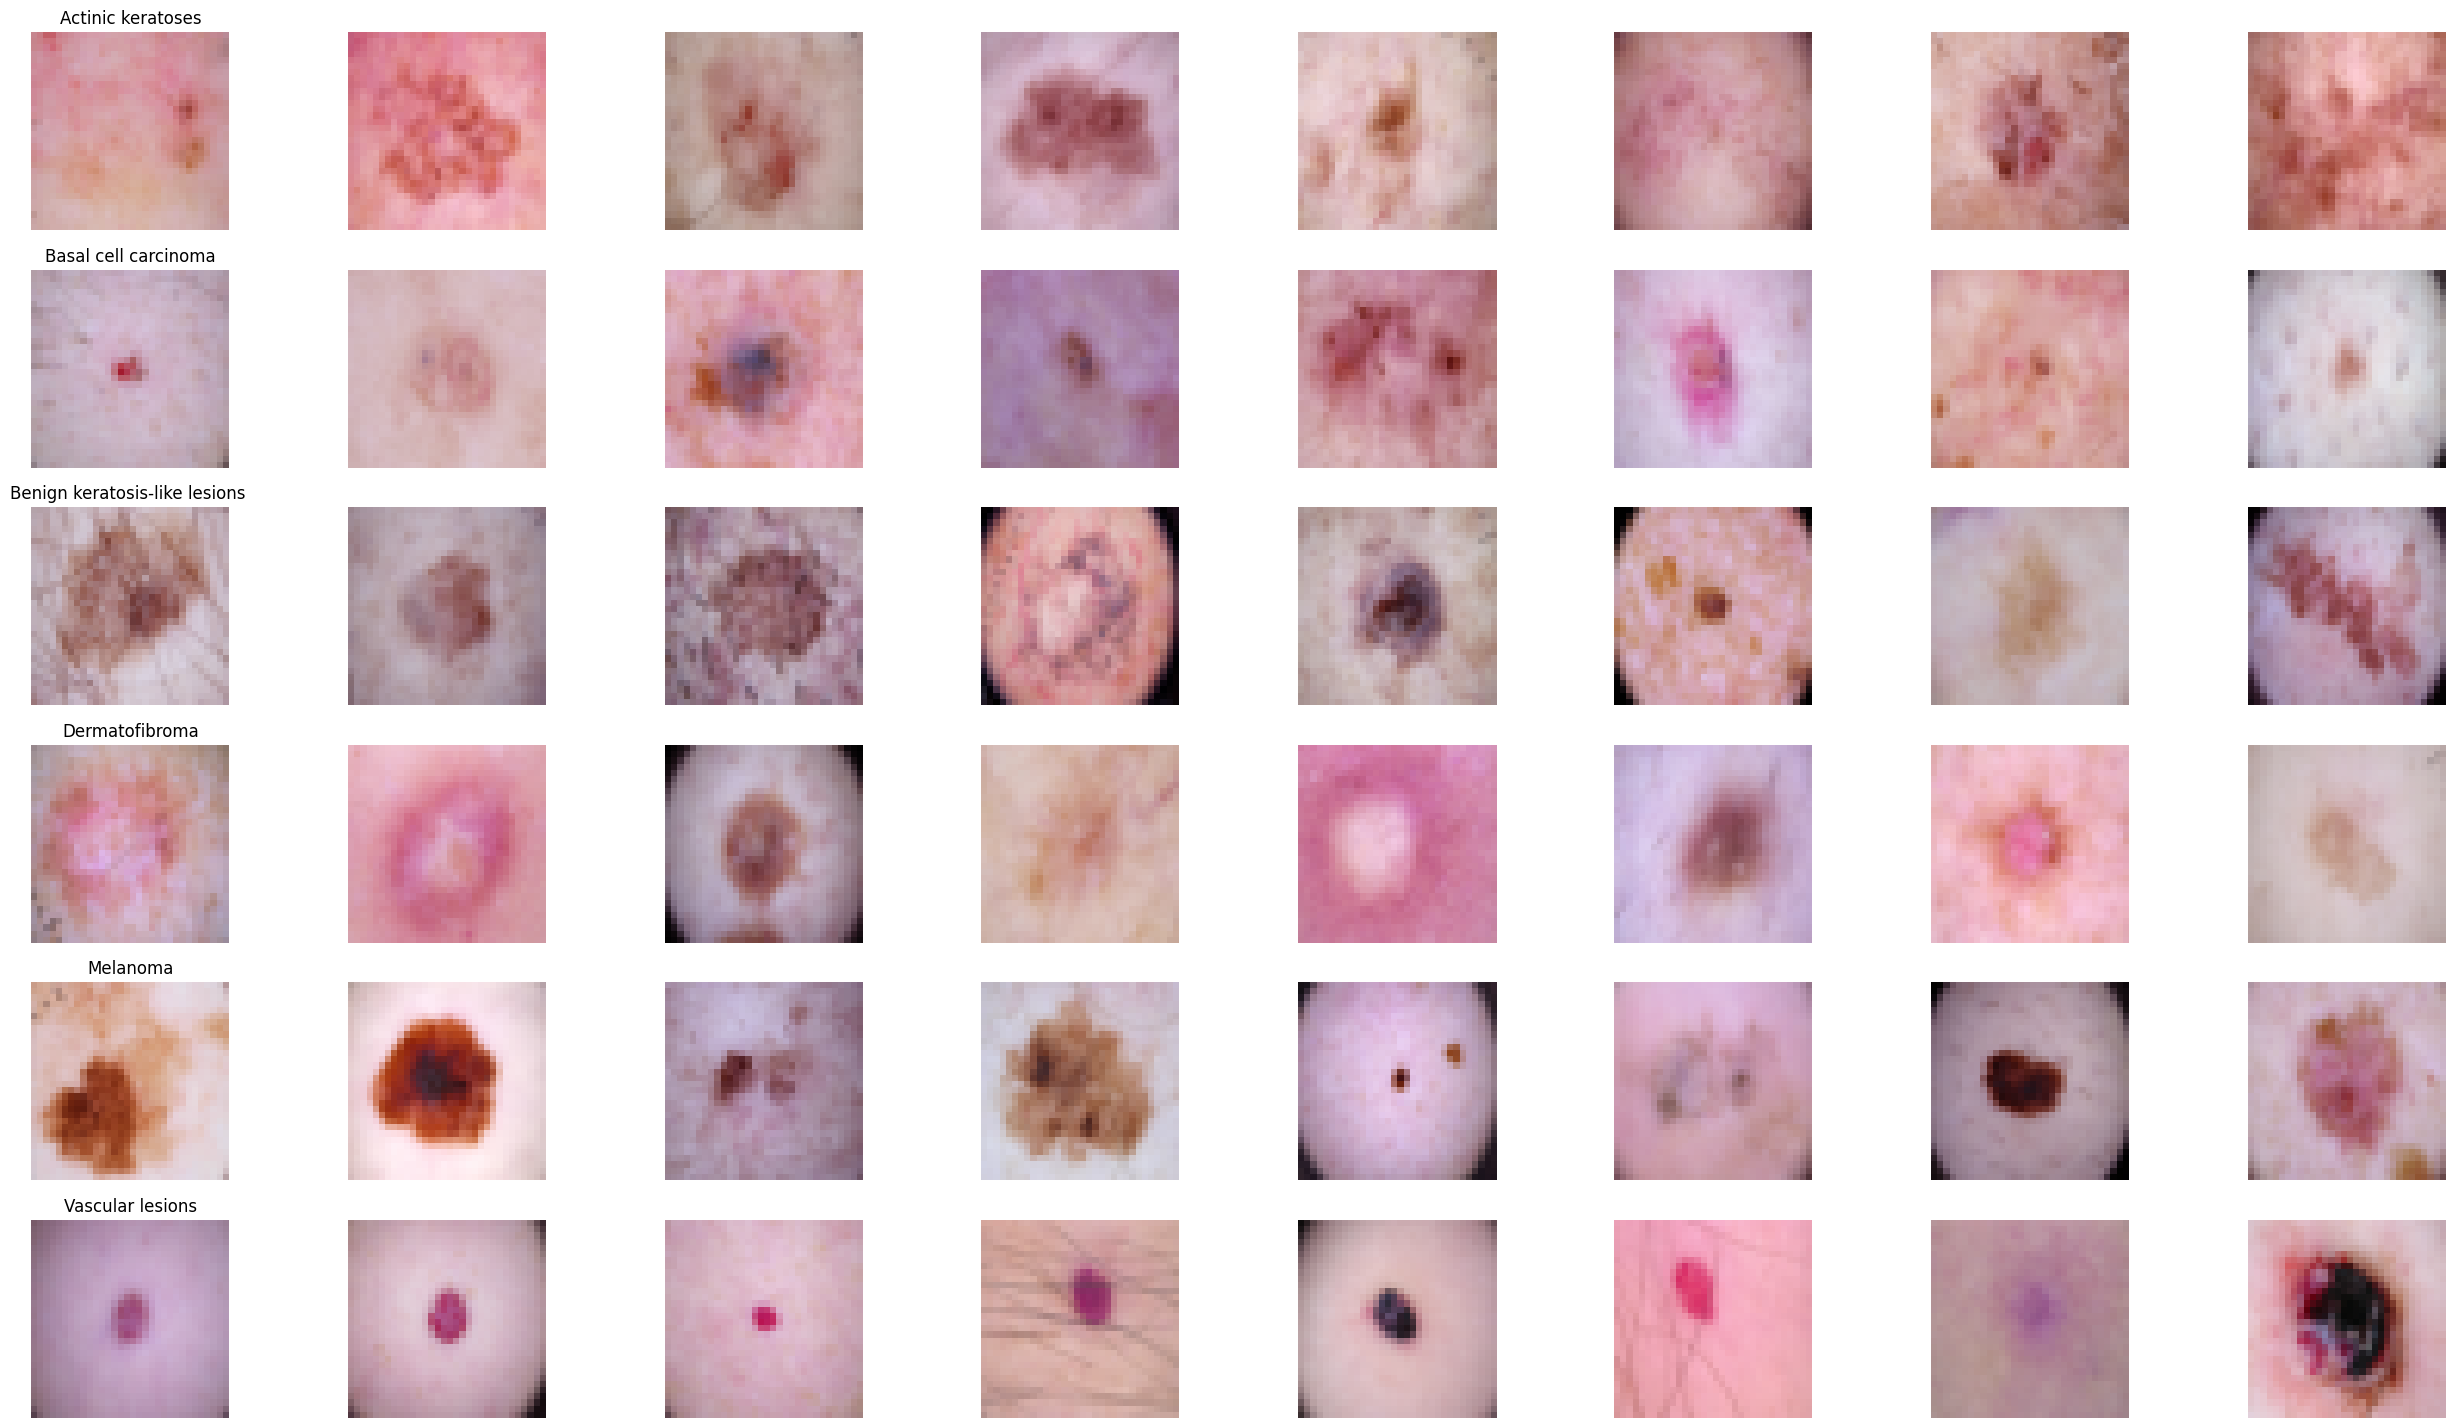

In [ ]:
# Find the unique types of skin lesions
unique_types = tile_df['cell_type'].unique()

# Get the number of unique types
num_unique_types = len(unique_types)

# Define the number of columns (samples per row)
n_samples = 8

# Create the subplot grid with the appropriate number of rows and columns
fig, m_axs = plt.subplots(num_unique_types, n_samples, figsize=(4 * n_samples, 3 * num_unique_types))

# Loop through the unique types and plot samples for each type
for n_axs, (type_name, type_rows) in zip(m_axs, tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Remove any empty subplots if there are fewer unique types than the number of rows
if num_unique_types < len(m_axs):
    for ax in m_axs.flat[num_unique_types * n_samples:]:
        ax.axis('off')

# Save the figure
fig.savefig('category_samples.png', dpi=300)

Export to csv

In [ ]:
tile_df.to_csv('processed_data.csv')

y = tile_df.cell_type_idx
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25)

Training the model

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_test_mean) / x_test_std

y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

# Model configuration
input_shape = (32, 32, 3)
num_classes = 7

# Define the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
initial_learning_rate = 0.001
opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 128)       147584    
                                                        

Fitting the model

In [ ]:
# Train the model with data augmentation
epochs = 50
batch_size = 128

history = model.fit(data_augmentation.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Epoch 1/50
19/19 [==============================] - 15s 125ms/step - loss: 4.7413 - accuracy: 0.3802 - val_loss: 3.2940 - val_accuracy: 0.4203
Epoch 2/50
19/19 [==============================] - 2s 79ms/step - loss: 2.5722 - accuracy: 0.4184 - val_loss: 2.0716 - val_accuracy: 0.4155
Epoch 3/50
19/19 [==============================] - 1s 77ms/step - loss: 1.7948 - accuracy: 0.4401 - val_loss: 1.5996 - val_accuracy: 0.4722
Epoch 4/50
19/19 [==============================] - 1s 77ms/step - loss: 1.5056 - accuracy: 0.4605 - val_loss: 1.4317 - val_accuracy: 0.4819
Epoch 5/50
19/19 [==============================] - 2s 79ms/step - loss: 1.4041 - accuracy: 0.4805 - val_loss: 1.3866 - val_accuracy: 0.5048
Epoch 6/50
19/19 [==============================] - 1s 77ms/step - loss: 1.3600 - accuracy: 0.4724 - val_loss: 1.3200 - val_accuracy: 0.5109
Epoch 7/50
19/19 [==============================] - 2s 122ms/step - loss: 1.2928 - accuracy: 0.4953 - val_loss: 1.2540 - val_accuracy: 0.5217
Epoch 8/50

Graphs for accuracy and loss during training and validation

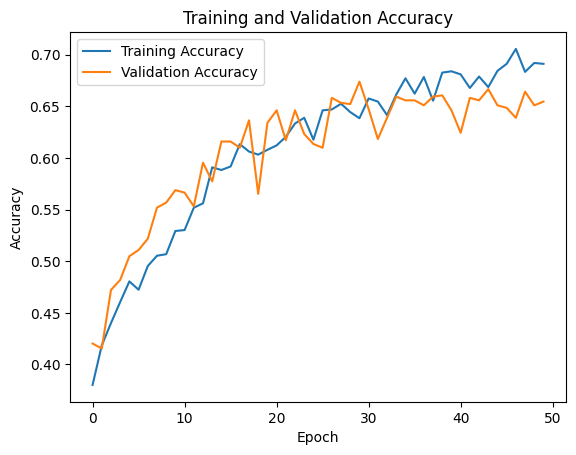

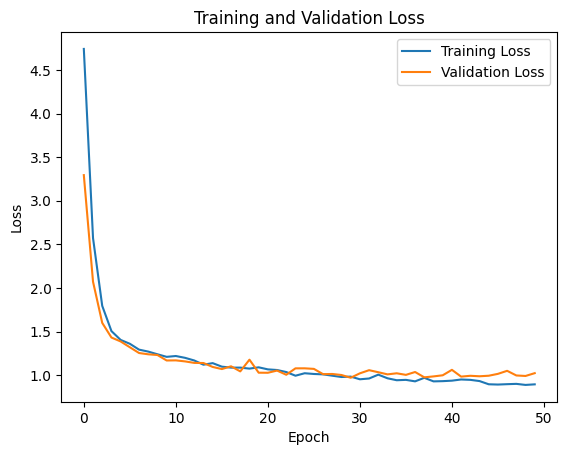

In [ ]:
# Train and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Train and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate the model on the test dataset and plot the accuracy and loss for the test dataset

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plot the accuracy and loss for the test dataset
predictions = model.predict(x_test)
test_labels = np.argmax(y_test, axis=1)
test_predictions = np.argmax(predictions, axis=1)

# Test accuracy
correct = np.sum(test_labels == test_predictions)
total = len(test_labels)
test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Test loss
test_loss = keras.losses.categorical_crossentropy(y_test, predictions).numpy().mean()
print(f'Test Loss: {test_loss:.4f}')

# Mapping class indices to lesion type names
lesion_type_dict = {
    0: 'Melanocytic nevi',
    1: 'Melanoma',
    2: 'Benign keratosis-like lesions',
    3: 'Basal cell carcinoma',
    4: 'Actinic keratoses',
    5: 'Vascular lesions',
    6: 'Dermatofibroma'
}

# Display the predictions and ground truth for a few examples
num_examples = 10
for i in range(num_examples):
    predicted_label = lesion_type_dict[test_predictions[i]]
    correct_label = lesion_type_dict[test_labels[i]]
    print(f"Example {i + 1}: Predicted: {predicted_label}, Correct: {correct_label}")


Test Loss: 1.0230, Test Accuracy: 0.6546
26/26 [==============================] - 0s 3ms/step
Test Accuracy: 0.6546
Test Loss: 0.9150
Example 1: Predicted: Vascular lesions, Correct: Vascular lesions
Example 2: Predicted: Melanocytic nevi, Correct: Melanocytic nevi
Example 3: Predicted: Benign keratosis-like lesions, Correct: Benign keratosis-like lesions
Example 4: Predicted: Melanocytic nevi, Correct: Basal cell carcinoma
Example 5: Predicted: Melanocytic nevi, Correct: Melanoma
Example 6: Predicted: Melanoma, Correct: Basal cell carcinoma
Example 7: Predicted: Benign keratosis-like lesions, Correct: Benign keratosis-like lesions
Example 8: Predicted: Benign keratosis-like lesions, Correct: Vascular lesions
Example 9: Predicted: Vascular lesions, Correct: Vascular lesions
Example 10: Predicted: Melanoma, Correct: Benign keratosis-like lesions


Save the model in SavedModel format


In [ ]:
# The SavedModel will be saved in a directory named 'skin_lesion_model'
model.save('skin_lesion_model')

# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model('skin_lesion_model')
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a specific directory in Colab runtime
output_path = '/content/skin_lesion_model.tflite'
with open(output_path, 'wb') as f:
    f.write(tflite_model)
